In [1]:
import qlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import statsmodels.api as sm
from qlib.data import D
from qlib.config import REG_CN
from qlib.contrib.data.handler import Alpha158
from qlib.data.filter import NameDFilter, ExpressionDFilter
from qlib.contrib.model.gbdt import LGBModel
from qlib.contrib.data.handler import Alpha158
from qlib.utils import init_instance_by_config, flatten_dict
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError. CatBoostModel are skipped. (optional: maybe installing CatBoostModel can fix it.)
ModuleNotFoundError. XGBModel is skipped(optional: maybe installing xgboost can fix it).
ModuleNotFoundError.  PyTorch models are skipped (optional: maybe installing pytorch can fix it).


In [2]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/day1_data_qlib', region=REG_CN)
expressionDFilter = ExpressionDFilter(rule_expression='$volume != 0')
instruments = D.instruments(market = 'all', filter_pipe=[expressionDFilter])
new = D.features(instruments = instruments, fields = ['$new'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
ST = D.features(instruments = instruments, fields = ['$ST'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
marketcap = D.features(instruments = instruments, fields = ['$marketcap'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
yjl = D.features(instruments = instruments, fields = ['$CONVERTIBLEPREMIUMRATE'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
data_close = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
data_open = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1day').unstack().T.droplevel(0)
# stock_list = D.list_instruments(instruments = instruments,
#                                 start_time='2022-01-01',
#                                 end_time='2025-03-31',
#                                 as_list=True)

[44276:MainThread](2025-06-24 09:41:04,340) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[44276:MainThread](2025-06-24 09:41:04,344) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[44276:MainThread](2025-06-24 09:41:04,344) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/day1_data_qlib')}


In [ ]:
OVD = pd.read_csv('C:/Users/tantra/Desktop/data/Fund_OptValueDev.csv')
OVD = OVD.pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
OVD.index = pd.to_datetime(OVD.index)
OVD = OVD.loc['2022-01-01':'2025-3-28'].dropna(how='all', axis=1)
#纯债溢价率
SPR = pd.read_csv('C:/Users/tantra/Desktop/data/Fund_StrbPremiumRate.csv')
SPR = SPR.pivot(index='TRADINGDATE', columns='SYMBOL9', values='FACTORVALUE')
SPR.index = pd.to_datetime(SPR.index)
SPR = SPR.loc['2022-01-01':'2025-3-28'].dropna(how='all', axis=1)

In [33]:
qlib.init(provider_uri='C:/Users/tantra/Desktop/data/min1_data_qlib', region=REG_CN)
instruments = D.instruments(market = 'all')

[44276:MainThread](2025-06-24 14:11:53,362) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[44276:MainThread](2025-06-24 14:11:53,362) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[44276:MainThread](2025-06-24 14:11:53,362) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/tantra/Desktop/data/min1_data_qlib')}


In [4]:
# 剔除当天正股为ST股的可转债的因子值,factor为dict格式
def exclude_ST(factor):
    for date in factor.keys():
        dates = date[:-2]
        factor[date] = factor[date][ST.loc[dates] == 0]
    return factor

# 剔除当天为新债的可转债的因子值，factor为dict格式
def exclude_newbond(factor):
    for date in factor.keys():
        dates = date[:-2]
        factor[date] = factor[date][new.loc[dates] == 0]
    return factor

# 缩尾处理将超过分位数的因子替换为边界值,factor为dict格式，low为下分位数，up为上分位数
def winsorize(factor,low = 0.01, up = 0.99):
    for date in factor.keys():
        s = factor[date].copy()
        lower = s.quantile(low)
        upper = s.quantile(up)
        factor[date] = s.clip(lower, upper)
    return factor

# 标准化处理,factor为dict格式
def factor_std(factor):
    for date in factor.keys():
        factor[date] = (factor[date] - factor[date].mean()) / factor[date].std()
    return factor

# 将dataframe格式的因子数据表变为dict格式,
def factor_dict(factor):
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    return factor_dict

# 对溢价率中性化,factor为dict格式
def net_yjl(factor):
    data_yjl = factor_dict(yjl)
    for date in factor.keys():
        y = factor[date].dropna()
        x = data_yjl[date].dropna()
        x, y = x.align(y, join='inner')
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 对市值中性化,factor为dict格式
def net_marketcap(factor):
    data_marketcap = factor_dict(marketcap)
    for date in factor.keys():
        y = factor[date].dropna()
        x = data_marketcap[date].dropna()
        x, y = x.align(y, join='inner')
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 对因子中性化，factor1为需要被中性化的因子，factor1为dataframe格式,factor_list为需要对其中性化的因子变量列表，列表中每一个变量是dataframe格式
def net_factor(factor1, factor_list):
    date_list = factor1.index
    for i in factor_list:
        date_list = date_list.intersection(i.index)
    factor = {}
    for date in date_list:
        factor_x = pd.DataFrame()
        for i in factor_list: 
            factor_x = pd.concat([factor_x, i.loc[date]], axis=1) 
        y = factor1.loc[date].dropna()
        x = factor_x.dropna()
        x, y = x.align(y, join='inner', axis=0)
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        factor[date] = model.resid.sort_values()
    return factor

# 制作相关系数矩阵,factor_list为因子变量的列表，每个元素为dataframe格式的因子，factor_name为因子名字符串的列表
def cal_corr_matrix(factor_list, factor_name):
    dict_factor = dict(zip(factor_name, factor_list))
    corr_matrix = pd.DataFrame(columns=factor_name, index=factor_name)
    for factor1 in factor_name:
        for factor2 in factor_name:
            corr_matrix.loc[factor1, factor2] = dict_factor[factor1].loc['2023-01-01':].corrwith(dict_factor[factor2].loc['2023-01-01':], axis=1).mean()
    return corr_matrix


In [5]:
# 计算因子每日分组收益率,N为分组数,factor为dict格式
def cal_group_return(factor, N):
    date_list = list(factor.keys())
    group_return={}
    if cal_RankIC_mean(factor) > 0:
        for date in date_list[:-1]:
            factor[date] = factor[date].dropna()
            stock_all = factor[date].index.tolist()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_close_part.shift(-1)/data_close_part - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group'+str(N)] - stock_return['group1']
            stock_return['benchmark'] = (data_close_part.loc[:,stock_all].shift(-1)/data_close_part.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    else:
        for date in date_list[:-1]:
            factor[date] = factor[date].dropna()
            stock_all = factor[date].index.tolist()
            stock_return={}
            for i in range(1,N+1):
                stock_i = factor[date].iloc[int(len(factor[date])/N*(i-1)):int(len(factor[date])/N*i)].index.tolist()
                stock_i_return = (data_close_part.shift(-1)/data_close_part - 1).loc[date,stock_i].mean()
                stock_return['group'+str(i)] = stock_i_return
            stock_return['long-short'] = stock_return['group1'] - stock_return['group'+str(N)]
            stock_return['benchmark'] = (data_close_part.loc[:,stock_all].shift(-1)/data_close_part.loc[:,stock_all] - 1).loc[date].mean()
            group_return[date] = pd.Series(stock_return)
    return group_return

In [6]:
# 计算分组每期换手率,factor为dict格式
def cal_group_turnover(factor, N):
    turnover = pd.DataFrame()
    for i in range(1,N+1):
        stock_amount = {}
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[int(len(factor[time].dropna())/N*(i-1)):int(len(factor[time].dropna())/N*i)].index)
        stock_amount = pd.Series(stock_amount)
        turnover_rate = pd.Series(index=stock_amount.index, name=f'group{i}')
        for i in range(1,len(stock_amount)):
            prev_set = stock_amount[i-1]
            current_set = stock_amount[i]
            new_elements = len(current_set - prev_set)
            turnover_rate[i] = new_elements / len(prev_set)
        turnover = pd.concat([turnover,turnover_rate], axis=1)
    return turnover

# 画出分组累积超额收益走势，factor为dict格式，N为组数
def plot_return(factor, N, turnover=0.0001):
    group_return = cal_group_return(factor, N)
    group_cum_return = pd.DataFrame(group_return).T.shift(1)
    group_turnover = cal_group_turnover(factor,N)
    for i in range(1,N+1):
        group_cum_return['group'+str(i)] = group_cum_return['group'+str(i)] - group_cum_return['benchmark'] - group_turnover['group'+str(i)] * turnover
    group_cum_return.iloc[0] = 0
    group_cum_return = group_cum_return.dropna(how='all')
    group_cum_return.cumsum().iloc[:,:N+1].plot()

# 计算年化收益率，factor为dict格式，N为组数
def cal_annual_return(factor, N):
    return (pd.DataFrame(cal_group_return(factor, N)).T).mean() * 504

# 计算每日RankIC值，factor为dict格式
def cal_RankIC(factor):
   factor = pd.DataFrame(factor)
   return factor.corrwith((data_close_part.shift(-1)/data_close_part-1).T, method = 'spearman')

# 计算每日RankIC均值，factor为dict格式
def cal_RankIC_mean(factor):
    RankIC = cal_RankIC(factor).mean()
    return RankIC

# 计算日度RankICIR值，factor为dict格式
def cal_RankICIR(factor):
    RankIC = cal_RankIC(factor)
    ICIR = RankIC.mean() / RankIC.std()
    return ICIR

# 计算分组累积超额收益,factor为dict格式,N为组数
def cal_alpha(factor, N):
    group_return = cal_group_return(factor, N)
    group_return = pd.DataFrame(group_return).T
    group_return_cumprod = (group_return + 1).cumprod()
    excess_Return = group_return_cumprod.sub(group_return_cumprod['benchmark'], axis = 0)
    return excess_Return.iloc[:,:-1]

# 计算多头年化超额,factor为dict格式，N为组数
def cal_long_return(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].mean() * 252
        return long
    
# 计算多头超额胜率,factor为dict格式，N为组数
def cal_long_winrate(factor, N):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group'+str(N)] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T
        long = group_return['group1'] - group_return['benchmark']
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    
# 计算年化夏普比率,factor为dict格式，N为组数，rate为无风险利率
def cal_sharp(factor, N, rate=0.02):
    annual_return = cal_annual_return(factor, N) - rate
    std = pd.DataFrame(cal_group_return(factor, N)).T.std() * math.sqrt(504)
    sharp = annual_return / std 
    return sharp

# 计算概率，factor为dict格式，N为组数
def cal_probability(factor, N):
    group_return = pd.DataFrame(cal_group_return(factor, N)).T.iloc[:,:-1]
    group_return = group_return.rolling(20).sum().dropna(how = 'all')
    group_cols = [col for col in group_return.columns[:N]]
    if cal_RankIC_mean(factor) < 0:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[0]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] >= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    else:
        for i in range(1,4):
            if i == 1:
                group_return['概率1'] = group_return.apply(lambda row: 1 if row[group_cols[0]] <= row[:N].min() else 0, axis=1)
            if i == 2:
                group_return['概率2'] = group_return.apply(lambda row: 1 if row[group_cols[-1]] >= row[:N].max() else 0, axis=1)
            if i == 3:
                group_return['概率3'] = group_return.apply(lambda row: 1 if all(row[group_cols[i]] <= row[group_cols[i+1]] for i in range(len(group_cols)-1)) else 0, axis=1)
        group_return['概率0'] = group_return.apply(lambda row: 1 if all( row['概率' + str(i)] != 1 for i in range(1,4)) else 0, axis=1)
    n = len(group_return.index)
    p0, p1, p2, p3 = group_return['概率0'].sum()/n, group_return['概率1'].sum()/n, group_return['概率2'].sum()/n, group_return['概率3'].sum()/n
    return pd.Series([p0,p1,p2,p3],index = ['概率0','概率1','概率2','概率3'])

In [7]:
# 计算多头每期换手率,factor为dict格式
def cal_turnover(factor, N):
    stock_amount = {}
    if cal_RankIC_mean(factor) < 0:
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[:int(len(factor[time].dropna())/N)].index)
    else:
        for time in factor.keys():
            stock_amount[time] = set(factor[time].dropna().iloc[int(len(factor[time].dropna())/N*(N-1)):].index)
    stock_amount = pd.Series(stock_amount)
    turnover_rate = pd.Series(index=stock_amount.index)
    for i in range(1,len(stock_amount)):
        prev_set = stock_amount[i-1]
        current_set = stock_amount[i]
        new_elements = len(current_set - prev_set)
        turnover_rate[i] = new_elements / len(prev_set)
    return turnover_rate

# 计算多头每日平均换手率，factor为dict格式
def cal_turnover_mean(factor, N):
    turnover_rate = cal_turnover(factor, N)
    grouped = turnover_rate.groupby(turnover_rate.index.map(lambda x: x[:-2])).sum()
    return grouped[1:].mean()

In [8]:
# 计算多头年化超额（考虑换手率）,factor为dict格式，N为组数
def cal_long_return_turnover(factor, N, turnover=0.0001):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group'+str(N)] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].mean() * 252
        return long
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group1'] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].mean() * 252
        return long
    
# 计算多头超额胜率（考虑换手率）,factor为dict格式，N为组数    
def cal_long_winrate_turnover(factor, N, turnover=0.0001):
    if cal_RankIC_mean(factor) > 0:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group'+str(N)] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate
    else:
        group_return = pd.DataFrame(cal_group_return(factor, N)).T.shift(1)
        long = group_return['group1'] - group_return['benchmark'] - cal_turnover(factor, N) * turnover
        long = long.groupby(long.index.map(lambda x: x[:-2])).sum()[1:-1].dropna()
        long_winrate = (long > 0).sum() / len(long)
        return long_winrate

In [459]:
group_return = pd.DataFrame(cal_group_return(factor_zp, 4)).T.shift(1)
group_return

,group1,group2,group3,group4,long-short,benchmark
2023-01-03p1,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03p2,0.004840,0.005494,0.004432,0.006886,-0.002046,0.005413
2023-01-04p1,0.006717,0.005979,0.004465,0.005221,0.001497,0.005595
2023-01-04p2,-0.000082,-0.000018,-0.001052,0.000161,-0.000242,-0.000248
2023-01-05p1,0.008175,0.006107,0.005993,0.002387,0.005788,0.005666
...,...,...,...,...,...,...
2025-03-26p1,0.007486,0.006235,0.005369,0.005520,0.001966,0.006153
2025-03-26p2,0.000015,-0.001470,-0.001390,-0.002362,0.002376,-0.001307
2025-03-27p1,0.000811,-0.000835,-0.003041,0.000250,0.000561,-0.000710
2025-03-27p2,0.000882,0.000160,0.000455,0.000794,0.000088,0.000572


In [ ]:
p1_index = [x for x in group_return.index if x.endswith('p1')]
p2_index = [x for x in group_return.index if x.endswith('p2')]
p3_index = [x for x in group_return.index if x.endswith('p3')]
p4_index = [x for x in group_return.index if x.endswith('p4')]

In [480]:
group_return_p1 = group_return.loc[p1_index]
group_return_p2 = group_return.loc[p2_index]
s1 = (group_return_p1['group'+str(1)] - group_return_p1['benchmark']).cumsum()
s2 = (group_return_p2['group'+str(1)] - group_return_p2['benchmark']).cumsum()
s1.index = [x[:-2] for x in s1.index]
s2.index = [x[:-2] for x in s2.index]
s1.name = 'p1'
s2.name = 'p2'

In [10]:
# 分池，factor为dataframe格式
def cal_pool_factor(factor):
    mark = pd.read_csv('C:/Users/tantra/Desktop/CBStyleMark.csv', parse_dates=['date'])
    factor_dict = {}
    for day in list(factor.index):
        factor_dict[day] = factor.loc[day].sort_values()
    pools = ['GP','ZP','DP']
    for pool in pools:
        if pool == 'GP':
            factor_day_GP = {}
            for date in factor_dict.keys():
                dates = date[:-2]
                mark1 = mark[mark['date'] == dates]
                mark1 = mark1[mark1['GP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_GP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'ZP':
            factor_day_ZP = {}
            for date in factor_dict.keys():
                dates = date[:-2]
                mark1 = mark[mark['date'] == dates]
                mark1 = mark1[mark1['ZP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_ZP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
        if pool == 'DP':
            factor_day_DP = {}
            for date in factor_dict.keys():
                dates = date[:-2]
                mark1 = mark[mark['date'] == dates]
                mark1 = mark1[mark1['DP'] == 1]
                pool_stocklist = mark1['SYMBOL9'].tolist()
                factor_day_DP[date] = factor_dict[date].loc[pool_stocklist].sort_values()
    return factor_day_GP,factor_day_ZP,factor_day_DP

In [44]:
# 分池因子分析，factor为dataframe格式，N为组数
def factor_analyse(factor, st=True, new=True, yjl=False, mar=False, win=True, std=True, N1=3, N2=4, N3=3):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额', '多头超额胜率', '多空夏普比率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc['2023-01-03p1':'2024-06-28p4']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc['2024-07-01p1':'2024-12-31p4']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc['2025-01-02p1':'2025-03-28p4']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return(factor_gp, N1), cal_long_winrate(factor_gp, N1), 
                                                   cal_sharp(factor_gp, N1, rate=0.02).tolist()[-2]] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return(factor_zp, N2), cal_long_winrate(factor_zp, N2), 
                                                   cal_sharp(factor_zp, N2, rate=0.02).tolist()[-2]] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return(factor_dp, N3), cal_long_winrate(factor_dp, N3), 
                                                   cal_sharp(factor_dp, N3, rate=0.02).tolist()[-2]] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df

In [45]:
# 分池因子分析（考虑换手），factor为dataframe格式，N为组数
def factor_analyse_turnover(factor, st=True, new=True, yjl=False, mar=False, win=True, std=True, N1=3, N2=4, N3=3):
    sample = ['训练期', '验证期', '测试期']
    features = ['RankICIR', '多头年化超额（换手）', '多头超额胜率（换手）', '日均换手率', '概率1', '概率2']
    pools = ['高平池', '中平池', '低平池']
    factor_summary = {}
    for sam in sample:
        if sam == '训练期':
            factor_df = factor.loc['2023-01-03p1':'2024-06-28p4']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
        if sam == '验证期':
            factor_df = factor.loc['2024-07-01p1':'2024-12-31p4']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool           
        if sam == '测试期':
            factor_df = factor.loc['2025-01-02p1':'2025-03-28p4']
            factor_pool = {}
            factor_gp, factor_zp, factor_dp = cal_pool_factor(factor_df)
            if st:
                factor_gp, factor_zp, factor_dp  = exclude_ST(factor_gp), exclude_ST(factor_zp), exclude_ST(factor_dp)
            if new:
                factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
            if yjl:
                factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
            if mar:
                factor_gp, factor_zp, factor_dp  = net_marketcap(factor_gp), net_marketcap(factor_zp), net_marketcap(factor_dp)  
            if win:
                factor_gp, factor_zp, factor_dp  = winsorize(factor_gp), winsorize(factor_zp), winsorize(factor_dp)
            if std:
                factor_gp, factor_zp, factor_dp  = factor_std(factor_gp), factor_std(factor_zp), factor_std(factor_dp)
            for pool in pools:
                if pool == '高平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_gp), cal_long_return_turnover(factor_gp, N1), cal_long_winrate_turnover(factor_gp, N1), 
                                                   cal_turnover_mean(factor_gp, N1)] + cal_probability(factor_gp, N1).tolist()[1:3], index = features) 
                if pool == '中平池': 
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_zp), cal_long_return_turnover(factor_zp, N2), cal_long_winrate_turnover(factor_zp, N2), 
                                                   cal_turnover_mean(factor_zp, N2)] + cal_probability(factor_zp, N2).tolist()[1:3], index = features)
                if pool == '低平池':
                    factor_pool[pool] = pd.Series([cal_RankICIR(factor_dp), cal_long_return_turnover(factor_dp, N3), cal_long_winrate_turnover(factor_dp, N3), 
                                                   cal_turnover_mean(factor_dp, N3)] + cal_probability(factor_dp, N3).tolist()[1:3], index = features)
        factor_summary[sam] = factor_pool
    df = pd.concat([pd.DataFrame(factor_summary['训练期']), pd.DataFrame(factor_summary['验证期']), pd.DataFrame(factor_summary['测试期'])], keys = sample, axis =1)
    return df

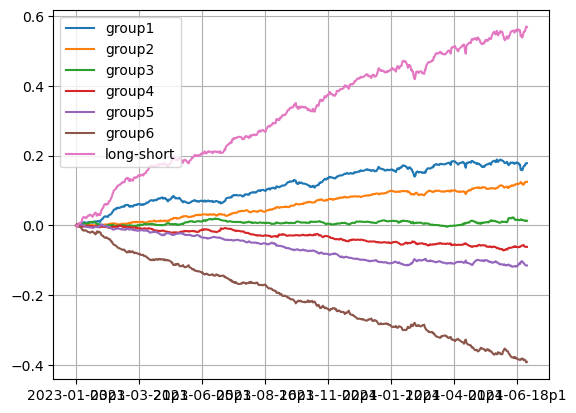

In [395]:
# 样本内
ret5_test = combined_factor.loc['2023-01-03p1':'2024-06-28p2']
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
# plot_return(factor_gp, 3)
plot_return(factor_zp, 6)
# plot_return(factor_dp, 3)
plt.grid(True)

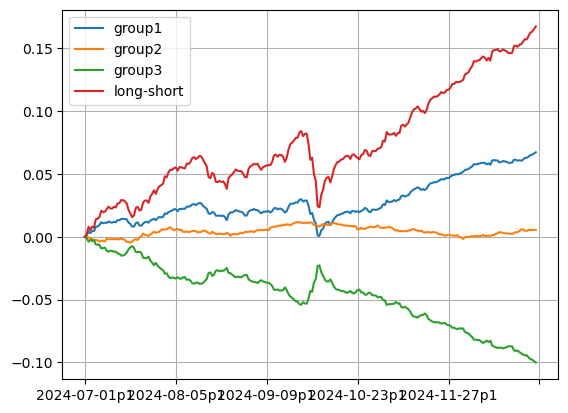

In [400]:
# 样本外
ret5_test = combined_factor.loc['2024-07-01p1':'2024-12-31p2']
factor_gp, factor_zp, factor_dp = cal_pool_factor(ret5_test)
#factor_gp, factor_zp, factor_dp  = net_yjl(factor_gp), net_yjl(factor_zp), net_yjl(factor_dp)
factor_gp, factor_zp, factor_dp  = exclude_newbond(factor_gp), exclude_newbond(factor_zp), exclude_newbond(factor_dp)
factor_gp, factor_zp, factor_dp  = factor_std(winsorize(factor_gp)), factor_std(winsorize(factor_zp)), factor_std(winsorize(factor_dp))
# plot_return(factor_gp, 3)
plot_return(factor_zp, 3)
# plot_return(factor_dp, 3)
plt.grid(True)

In [34]:
data_open_min = D.features(instruments = instruments, fields = ['$open'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1min').unstack().T.droplevel(0)
data_high_min = D.features(instruments = instruments, fields = ['$high'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1min').unstack().T.droplevel(0)
data_low_min = D.features(instruments = instruments, fields = ['$low'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1min').unstack().T.droplevel(0)
data_close_min = D.features(instruments = instruments, fields = ['$close'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1min').unstack().T.droplevel(0)
data_volume_min = D.features(instruments = instruments, fields = ['$volume'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1min').unstack().T.droplevel(0)
data_amount_min = D.features(instruments = instruments, fields = ['$amount'], start_time = '2022-01-01', end_time = '2025-03-31', freq = '1min').unstack().T.droplevel(0)


In [14]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-3-28'].index]
for date in date_list:
    data_close_min.loc[date] = data_close_min.loc[date].fillna(method = 'ffill')

In [15]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-3-28'].index]
for date in date_list:
    data_open_min.loc[date] = data_open_min.loc[date].fillna(method = 'ffill')

In [16]:
date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-3-28'].index]
time_list = []
for date in date_list:
    time_list = time_list + [date + 'p1', date + 'p2', date + 'p3', date + 'p4']

In [26]:
data_close_part = {}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=30)
        data_close_part[time] = data_close_min.loc[target_datetime]
    if time.endswith('p2'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data_close_part[time] = data_close_min.loc[target_datetime]
    if time.endswith('p3'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=14)
        data_close_part[time] = data_close_min.loc[target_datetime]
    if time.endswith('p4'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=15)
        data_close_part[time] = data_close_min.loc[target_datetime]
data_close_part = pd.DataFrame(data_close_part).T

data_open_part = {}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        try:
            target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
            data_open_part[time] = data_open_min.loc[target_datetime]
        except:
            data_open_part[time] = data_open_min.loc[date].iloc[0]
    if time.endswith('p2'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=31)
        data_open_part[time] = data_open_min.loc[target_datetime]
    if time.endswith('p3'):
        try:
            target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=13, minutes=31)
            data_open_part[time] = data_open_min.loc[target_datetime]
        except:
            target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
            data_open_part[time] = data_close_min.loc[target_datetime]
    if time.endswith('p4'):
        target_datetime = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=1)
        data_open_part[time] = data_open_min.loc[target_datetime]
data_open_part = pd.DataFrame(data_open_part).T

In [29]:
data_compare_True = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_True.csv', parse_dates=['datetime'], index_col='datetime')
data_compare_False = pd.read_csv('C:/Users/tantra/Desktop/data/比较表格/data_compare_False.csv', parse_dates=['datetime'], index_col='datetime')

date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-3-28'].index]
drop_index =[]
for date in date_list:
    drop_index.extend([data_compare_True.loc[date].index[0], data_compare_True.loc[date].index[-1]])
data_compare_True.drop(index = drop_index, inplace = True)
data_compare_False.drop(index = drop_index, inplace = True)

In [30]:
# # 成交量比率合成因子
# date_list = [date.strftime('%Y-%m-%d') for date in data_close.loc['2022-1-1':'2025-3-28'].index]

# # data_compare_True = data_close_min.copy()
# # for date in date_list:
# #     data_compare_True.loc[date] = data_close_min.loc[date] > data_close_min.loc[date].shift(1)

# # data_compare_False = data_close_min.copy()
# # for date in date_list:
# #     data_compare_False.loc[date] = data_close_min.loc[date] <= data_close_min.loc[date].shift(1)

# drop_index =[]
# for date in date_list:
#     drop_index.extend([data_compare_True.loc[date].index[0], data_compare_True.loc[date].index[-1]])
# data_compare_True.drop(index = drop_index, inplace = True)
# data_compare_False.drop(index = drop_index, inplace = True)

factor = {}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=30)
        factor[time] = data_volume_min.loc[begain_time:end_time][data_compare_True.loc[begain_time:end_time]].sum() / data_volume_min.loc[begain_time:end_time][data_compare_False.loc[begain_time:end_time]].sum()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=31)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        factor[time] = data_volume_min.loc[begain_time:end_time][data_compare_True.loc[begain_time:end_time]].sum() / data_volume_min.loc[begain_time:end_time][data_compare_False.loc[begain_time:end_time]].sum()
    if time.endswith('p3'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14)
        factor[time] = data_volume_min.loc[begain_time:end_time][data_compare_True.loc[begain_time:end_time]].sum() / data_volume_min.loc[begain_time:end_time][data_compare_False.loc[begain_time:end_time]].sum()
    if time.endswith('p4'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        factor[time] = data_volume_min.loc[begain_time:end_time][data_compare_True.loc[begain_time:end_time]].sum() / data_volume_min.loc[begain_time:end_time][data_compare_False.loc[begain_time:end_time]].sum()   
factor= pd.DataFrame(factor).T 
factor1 = factor
# def weight_sum(series, N=2):
#     weight = 1 / (sum(range(1,N+1)) / N)
#     weight = pd.Series(range(1,N+1), index = series.index) * weight / N
#     return (series * weight).sum()

# factor_1 = factor_dict(factor.rolling(10).mean())
# factor_2 = factor_dict(factor.rolling(2).apply(weight_sum))
# # 合成因子,factor1、factor2为dict格式
# def factor_combine(factor1, factor2, n1, n2):
#     factor1 = winsorize(factor1)
#     factor2 = winsorize(factor2)
#     factor1 = factor_std(factor1)
#     factor2 = factor_std(factor2)
#     factor1 = pd.DataFrame(factor1).T
#     factor2 = pd.DataFrame(factor2).T
#     conbined_factor = n1 * factor1 + n2 * factor2
#     return conbined_factor

# factor1 = factor_combine(factor_1, factor_2, 0.3, 0.7)
# factor1.dropna(how='all', inplace=True)

In [245]:
factor_analyse(factor1)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.251361 -0.419534 -0.462402 -0.195669 -0.451998 -0.350000   
多头年化超额    0.025777  0.052714  0.046193  0.027238  0.072768  0.015051   
多头超额胜率    0.490934  0.552301  0.567643  0.506024  0.558233  0.558233   
多空夏普比率    1.136142  2.895094  2.787127  0.503803  2.934316  1.062163   
概率1       0.475645  0.521490  0.598854  0.386957  0.417391  0.473913   
概率2       0.343840  0.416905  0.442693  0.265217  0.439130  0.469565   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.236997 -0.465376 -0.534821  
多头年化超额    0.007788  0.079643  0.049349  
多头超额胜率    0.504505  0.549550  0.576577  
多空夏普比率   -0.254127  4.551387  3.945417  
概率1       0.043478  0.695652  0.815217  
概率2       0.347826  0.521739  0.652174

In [31]:
factor_analyse_turnover(factor1)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.305581 -0.446273 -0.432904 -0.211454 -0.507065 -0.519827   
多头年化超额（换手）  0.016789 -0.000629  0.013182  0.120742  0.094791  0.066259   
多头超额胜率（换手）  0.498599  0.490196  0.526611  0.544715  0.634146  0.577236   
日均换手率       2.584594  2.765467  2.461722  2.577072  2.831790  2.496350   
概率1         0.511315  0.670438  0.677511  0.506276  0.761506  0.721757   
概率2         0.403112  0.347242  0.548091  0.462343  0.520921  0.631799   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.147055 -0.488297 -0.429151  
多头年化超额（换手） -0.009938  0.054479 -0.009148  
多头超额胜率（换手）  0.555556  0.555556  0.518519  
日均换手率       2.572515  2.796345  2.484348  
概率1         0.341584  0.693069  0.712871  
概率2         0.366337  0.405941  0.495050

In [46]:
def weight_sum(series, N=6):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor1.rolling(8).mean())

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.152531 -0.219433 -0.166554 -0.138194 -0.265232 -0.176878   
多头年化超额（换手）  0.029777 -0.000066 -0.005351  0.091063  0.040002 -0.036714   
多头超额胜率（换手）  0.504202  0.495798  0.501401  0.569106  0.512195  0.471545   
日均换手率       0.843729  0.866269  0.742775  0.838509  0.900603  0.754519   
概率1         0.512712  0.432203  0.474576  0.629167  0.447917  0.481250   
概率2         0.383475  0.318503  0.358051  0.418750  0.350000  0.339583   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.172730 -0.292083 -0.205313  
多头年化超额（换手）  0.065346  0.076474  0.015197  
多头超额胜率（换手）  0.537037  0.629630  0.574074  
日均换手率       0.847159  0.915267  0.791471  
概率1         0.519608  0.593137  0.671569  
概率2         0.313725  0.509804  0.475490

In [47]:
# # 估波指标
# def cal_factor(series):
#     R1 = series / series.shift(1) - 1
#     R2 = series / series.shift(2) - 1
#     RC = R1 + R2
#     return RC.mean()

factor2 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        R1 = data / data.shift(1) - 1
        R2 = data / data.shift(2) - 1
        factor2[time] = (R1 + R2).mean()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=31)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        R1 = data / data.shift(1) - 1
        R2 = data / data.shift(2) - 1
        factor2[time] = (R1 + R2).mean()
    if time.endswith('p3'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14)
        data = data_close_min.loc[begain_time:end_time]
        R1 = data / data.shift(1) - 1
        R2 = data / data.shift(2) - 1
        factor2[time] = (R1 + R2).mean()
    if time.endswith('p4'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        data = data_close_min.loc[begain_time:end_time]
        R1 = data / data.shift(1) - 1
        R2 = data / data.shift(2) - 1
        factor2[time] = (R1 + R2).mean()
factor2 = pd.DataFrame(factor2).T

# def weight_sum(series, N=3):
#     weight = 1 / (sum(range(1,N+1)) / N)
#     weight = pd.Series(range(1,N+1), index=series.index) * weight / N
#     return (series * weight).sum()

# factor2 = factor_new.rolling(3).apply(weight_sum)
# factor2.dropna(how='all', inplace=True)

In [49]:
def weight_sum(series, N=8):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor2.rolling(8).apply(weight_sum))

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.182463 -0.434475 -0.558735 -0.162085 -0.414208 -0.421788   
多头年化超额（换手）  0.018141  0.179548  0.154320  0.084886  0.227831  0.199219   
多头超额胜率（换手）  0.504202  0.635854  0.719888  0.577236  0.691057  0.658537   
日均换手率       0.980974  1.198269  1.046999  1.019896  1.225788  1.072533   
概率1         0.573446  0.762712  0.841102  0.622917  0.787500  0.756250   
概率2         0.317090  0.668079  0.767655  0.433333  0.618750  0.702083   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.220150 -0.614777 -0.780378  
多头年化超额（换手）  0.340246  0.288028  0.288103  
多头超额胜率（换手）  0.518519  0.814815  0.888889  
日均换手率       1.041544  1.262995  1.171648  
概率1         0.607843  0.857843  0.931373  
概率2         0.534314  0.735294  1.000000

In [356]:
factor3 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        factor_value = return_std_std.corrwith(data_amount_min)
        factor3[time] = factor_value
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        data = data_close_min.loc[begain_time:end_time]
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        factor_value = return_std_std.corrwith(data_amount_min)
        factor3[time] = factor_value
factor3 = pd.DataFrame(factor3).T

In [357]:
factor_analyse(factor3)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.374294 -0.158330 -0.126225 -0.357999 -0.332630 -0.180792   
多头年化超额    0.064813  0.017738  0.023281  0.150735  0.023693  0.008186   
多头超额胜率    0.572626  0.500000  0.572626  0.637097  0.548387  0.532258   
多空夏普比率    2.047568  0.496559  0.770325  3.339036  3.044527 -1.089926   
概率1       0.560172  0.432665  0.448424  0.578261  0.630435  0.326087   
概率2       0.393983  0.265043  0.428367  0.539130  0.282609  0.452174   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.257241 -0.317979 -0.090902  
多头年化超额    0.005467 -0.015908 -0.017717  
多头超额胜率    0.545455  0.527273  0.418182  
多空夏普比率   -0.376255  0.890249 -2.237832  
概率1       0.253165  0.544304  0.265823  
概率2       0.405063  0.126582  0.240506

In [51]:
factor4 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        data_abs = np.abs(data - data.shift(1))
        SU = data_abs[data_compare_True.loc[begain_time:end_time]].sum()
        SD = data_abs[data_compare_False.loc[begain_time:end_time]].sum()
        factor4[time] = (SU - SD) / (SU + SD)
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=31)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        data_abs = np.abs(data - data.shift(1))
        SU = data_abs[data_compare_True.loc[begain_time:end_time]].sum()
        SD = data_abs[data_compare_False.loc[begain_time:end_time]].sum()
        factor4[time] = (SU - SD) / (SU + SD)
    if time.endswith('p3'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14)
        data = data_close_min.loc[begain_time:end_time]
        data_abs = np.abs(data - data.shift(1))
        SU = data_abs[data_compare_True.loc[begain_time:end_time]].sum()
        SD = data_abs[data_compare_False.loc[begain_time:end_time]].sum()
        factor4[time] = (SU - SD) / (SU + SD)
    if time.endswith('p4'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        data = data_close_min.loc[begain_time:end_time]
        data_abs = np.abs(data - data.shift(1))
        SU = data_abs[data_compare_True.loc[begain_time:end_time]].sum()
        SD = data_abs[data_compare_False.loc[begain_time:end_time]].sum()
        factor4[time] = (SU - SD) / (SU + SD)

factor4 = pd.DataFrame(factor4).T

In [53]:
def weight_sum(series, N=8):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor4.rolling(8).apply(weight_sum))

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.180852 -0.492959 -0.502381 -0.165594 -0.516750 -0.577730   
多头年化超额（换手）  0.052947  0.121881  0.105756  0.180604  0.165039  0.192001   
多头超额胜率（换手）  0.532213  0.647059  0.711485  0.585366  0.691057  0.707317   
日均换手率       1.088156  1.254380  1.097823  1.096774  1.271505  1.126456   
概率1         0.573446  0.779661  0.776130  0.737500  0.831250  0.847917   
概率2         0.351695  0.478814  0.718927  0.508333  0.600000  0.762500   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.228898 -0.764754 -0.835815  
多头年化超额（换手）  0.270604  0.226771  0.208260  
多头超额胜率（换手）  0.666667  0.814815  0.777778  
日均换手率       1.107747  1.307077  1.149639  
概率1         0.745098  0.754902  0.906863  
概率2         0.529412  0.666667  0.946078

In [274]:
# # 模糊金额比因子
# def cal_factor(series):
#     series = series[1:-1]
#     min_index = series.index
#     return_min = series / series.shift(1) - 1
#     return_std = return_min.rolling(5).std()
#     return_std_std = return_std.rolling(5).std()
#     return_std_std_mean = return_std_std.mean()
#     return data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()

factor5 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        min_index = data.index
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        return_std_std_mean = return_std_std.mean()
        factor5[time] = data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        data = data_close_min.loc[begain_time:end_time]
        min_index = data.index
        return_min = data / data.shift(1) - 1
        return_std = return_min.rolling(5).std()
        return_std_std = return_std.rolling(5).std()
        return_std_std_mean = return_std_std.mean()
        factor5[time] = data_amount_min.loc[min_index][return_std_std > return_std_std_mean].mean() / data_amount_min.loc[min_index].mean()
factor5 = pd.DataFrame(factor5).T

In [95]:
factor_analyse(factor5)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.261979 -0.127640 -0.018238 -0.203329 -0.200761  0.019559   
多头年化超额    0.050569  0.001039  0.018346  0.103114  0.018955 -0.012917   
多头超额胜率    0.541144  0.485356  0.513250  0.530120  0.526104  0.465863   
多空夏普比率    1.359805  0.363474  0.624899  2.807276  2.497267  0.678981   
概率1       0.487106  0.375358  0.449857  0.630435  0.569565  0.460870   
概率2       0.402579  0.230659  0.388252  0.565217  0.247826  0.282609   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.450201 -0.280365 -0.123269  
多头年化超额    0.181501  0.000656  0.025161  
多头超额胜率    0.603604  0.459459  0.495495  
多空夏普比率    3.668514  1.019040  0.384275  
概率1       0.632911  0.240506  0.569620  
概率2       0.772152  0.177215  0.329114

In [54]:
# 动量修正因子
factor6 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        close_max = data.rolling(2).max()
        factor6[time] = ((data - data.shift(1)) / close_max).mean()
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=10, minutes=31)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        data = data_close_min.loc[begain_time:end_time]
        close_max = data.rolling(2).max()
        factor6[time] = ((data - data.shift(1)) / close_max).mean()
    if time.endswith('p3'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=14)
        data = data_close_min.loc[begain_time:end_time]
        close_max = data.rolling(2).max()
        factor6[time] = ((data - data.shift(1)) / close_max).mean()
    if time.endswith('p4'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=14, minutes=1)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        data = data_close_min.loc[begain_time:end_time]
        close_max = data.rolling(2).max()
        factor6[time] = ((data - data.shift(1)) / close_max).mean()
factor6 = pd.DataFrame(factor6).T

In [56]:
def weight_sum(series, N=8):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor6.rolling(8).apply(weight_sum))

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.197425 -0.434900 -0.583286 -0.156835 -0.430634 -0.429919   
多头年化超额（换手）  0.056721  0.189466  0.166542  0.106026  0.212283  0.209398   
多头超额胜率（换手）  0.529412  0.641457  0.719888  0.552846  0.691057  0.626016   
日均换手率       0.980984  1.194064  1.063026  0.998902  1.210398  1.071368   
概率1         0.616525  0.757768  0.836158  0.656250  0.785417  0.766667   
概率2         0.359463  0.697034  0.788842  0.450000  0.672917  0.743750   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.207382 -0.618635 -0.817080  
多头年化超额（换手）  0.370198  0.304717  0.317984  
多头超额胜率（换手）  0.574074  0.833333  0.907407  
日均换手率       1.010580  1.248383  1.193885  
概率1         0.642157  0.803922  0.931373  
概率2         0.612745  0.735294  1.000000

In [402]:
factor9 ={}
for time in time_list:
    date = time[:-2]
    if time.endswith('p1'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=9, minutes=30)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=11, minutes=30)
        high_low = data_high_min.loc[begain_time:end_time] - data_low_min.loc[begain_time:end_time]
        close_high = data_close_min.loc[begain_time:end_time].shift(1) - data_high_min.loc[begain_time:end_time]
        abs_close_low = np.abs(data_close_min.loc[begain_time:end_time].shift(1) - data_low_min.loc[begain_time:end_time])
        atr = np.maximum(np.maximum(high_low, close_high), abs_close_low)
        ATR = atr.iloc[1:-1].mean()
        factor9[time] = ATR
    if time.endswith('p2'):
        begain_time = pd.to_datetime(date) + pd.Timedelta(hours=13)
        end_time = pd.to_datetime(date) + pd.Timedelta(hours=15)
        high_low = data_high_min.loc[begain_time:end_time] - data_low_min.loc[begain_time:end_time]
        close_high = data_close_min.loc[begain_time:end_time].shift(1) - data_high_min.loc[begain_time:end_time]
        abs_close_low = np.abs(data_close_min.loc[begain_time:end_time].shift(1) - data_low_min.loc[begain_time:end_time])
        atr = np.maximum(np.maximum(high_low, close_high), abs_close_low)
        ATR = atr.iloc[1:-1].mean()
        factor9[time] = ATR
factor9 = pd.DataFrame(factor9).T

In [403]:
factor_analyse(factor9)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.379200 -0.095031 -0.074814 -0.425649 -0.241901 -0.209071   
多头年化超额    0.065756 -0.041632 -0.026504  0.170669 -0.025761 -0.026025   
多头超额胜率    0.539106  0.458101  0.497207  0.620968  0.588710  0.524194   
多空夏普比率    1.807551 -1.003218 -1.009338  2.632406  1.001195 -0.711832   
概率1       0.564470  0.323782  0.333811  0.691304  0.582609  0.530435   
概率2       0.361032  0.227794  0.316619  0.526087  0.182609  0.365217   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.160395 -0.134588  0.012509  
多头年化超额   -0.088569 -0.026986  0.073593  
多头超额胜率    0.509091  0.527273  0.527273  
多空夏普比率   -1.047789 -0.173573  2.512482  
概率1       0.293478  0.445652  0.717391  
概率2       0.206522  0.152174  0.728261

In [410]:
cal_corr_matrix([factor1, factor_2, factor_3, factor_5, factor_6, factor_4, factor_9],['factor1','factor_2','factor_3','factor_5','factor_6','factor_4','factor_9'])#['成交量比率', '估波指标', '模糊金额比', '动量修正', '钱德动量摆动'] )#['溢价率', '期权价值偏移', '纯债溢价率', '成交量比率合成因子', '估波指标', '模糊金额比', '随波逐流'])

,factor1,factor_2,factor_3,factor_5,factor_6,factor_4,factor_9
factor1,1.0,0.19078,0.093075,0.066144,0.215576,0.286924,0.117967
factor_2,0.19078,1.0,0.056827,0.120671,0.938055,0.666786,0.08349
factor_3,0.093075,0.056827,1.0,0.641753,0.039937,0.024462,0.478585
factor_5,0.066144,0.120671,0.641753,1.0,0.108761,0.079893,0.1536
factor_6,0.215576,0.938055,0.039937,0.108761,1.0,0.668394,0.045789
factor_4,0.286924,0.666786,0.024462,0.079893,0.668394,1.0,0.027046
factor_9,0.117967,0.08349,0.478585,0.1536,0.045789,0.027046,1.0


In [ ]:
factor1_net = pd.DataFrame(net_factor(factor1,[factor2])).T
factor2_net = pd.DataFrame(net_factor(factor2,[yjl,OVD,SPR,factor1_net])).T
factor8_net = pd.DataFrame(net_factor(factor8, [yjl,OVD,SPR,factor1_net,factor2_net])).T
factor5_net = pd.DataFrame(net_factor(factor5, [yjl,OVD,SPR,factor1_net,factor2_net,factor8_net])).T

In [255]:
factor2_net = pd.DataFrame(net_factor(factor2,[factor4])).T
factor_analyse(factor2_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.126116  0.110530  0.660262  0.136998  0.319343  0.537965   
多头年化超额    0.005145  0.003670  0.114360  0.126617  0.053256  0.129029   
多头超额胜率    0.500000  0.477654  0.701117  0.491935  0.556452  0.629032   
多空夏普比率    0.684905  0.804128  5.343746  3.076223  4.235775  3.928087   
概率1       0.462751  0.434097  0.936963  0.721739  0.865217  0.713043   
概率2       0.277937  0.257880  0.707736  0.478261  0.239130  0.643478   

               测试期                       
               高平池       中平池        低平池  
RankICIR -0.298712  0.071306   0.831350  
多头年化超额    0.166613 -0.059430   0.099182  
多头超额胜率    0.527273  0.418182   0.763636  
多空夏普比率    2.408641 -0.548697  10.616071  
概率1       0.510870  0.521739   1.000000  
概率2       0.521739  0.043478   0.402174

In [324]:
factor_6_net = pd.DataFrame(net_factor(factor_6,[factor_4])).T
factor_analyse(factor_6_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.115848  0.052203  0.356158 -0.135482  0.159343  0.349924   
多头年化超额    0.031166 -0.018246  0.041678  0.001829 -0.007567  0.170899   
多头超额胜率    0.494413  0.474860  0.625698  0.500000  0.508065  0.645161   
多空夏普比率    0.752642 -0.611537  1.784608  0.453013  1.280950  4.300443   
概率1       0.464183  0.361032  0.702006  0.534783  0.447826  0.547826   
概率2       0.373926  0.200573  0.551576  0.260870  0.208696  0.713043   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.184264  0.125134  0.699991  
多头年化超额    0.063788 -0.031341  0.105435  
多头超额胜率    0.454545  0.490909  0.672727  
多空夏普比率    0.372015 -1.233549  6.597659  
概率1       0.402174  0.152174  0.902174  
概率2       0.445652  0.032609  0.880435

In [416]:
factor9_net = pd.DataFrame(net_factor(factor_9,[factor_5])).T
factor_analyse(factor9_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.373019 -0.103143 -0.072242 -0.392005 -0.194821 -0.166979   
多头年化超额    0.073736 -0.032444 -0.025704  0.100524 -0.009480 -0.010921   
多头超额胜率    0.567039  0.491620  0.491620  0.596774  0.572581  0.524194   
多空夏普比率    1.821955 -0.679576 -0.990439  2.137607  1.137305 -0.626147   
概率1       0.593123  0.393983  0.378223  0.656522  0.556522  0.373913   
概率2       0.393983  0.255014  0.263610  0.404348  0.321739  0.343478   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.076178 -0.082643  0.015336  
多头年化超额   -0.239676 -0.050962  0.074215  
多头超额胜率    0.431373  0.529412  0.588235  
多空夏普比率   -2.569833 -0.720363  2.501967  
概率1       0.130952  0.309524  0.440476  
概率2       0.059524  0.083333  0.726190

In [417]:
factor3_net = pd.DataFrame(net_factor(factor_3,[factor_5, factor9_net])).T
factor_analyse(factor3_net)

训练期                           验证期                      \
               高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR -0.188363 -0.105681 -0.115105 -0.134561 -0.076322 -0.052487   
多头年化超额   -0.059717 -0.038172  0.013665 -0.163030 -0.105666 -0.084913   
多头超额胜率    0.472067  0.438547  0.572626  0.379032  0.419355  0.395161   
多空夏普比率   -0.671391 -2.077984  0.176640 -2.575746 -3.490991 -2.724348   
概率1       0.348138  0.272206  0.388252  0.204348  0.256522  0.208696   
概率2       0.184814  0.210602  0.346705  0.108696  0.043478  0.173913   

               测试期                      
               高平池       中平池       低平池  
RankICIR -0.046819 -0.136123 -0.180867  
多头年化超额   -0.154529 -0.074651 -0.002536  
多头超额胜率    0.431373  0.450980  0.549020  
多空夏普比率   -2.433277 -3.053025 -0.515015  
概率1       0.130952  0.166667  0.321429  
概率2       0.285714  0.047619  0.238095

In [418]:
#factor1_std = factor_std(winsorize(factor_dict(factor1)))
factor2_std = factor_std(winsorize(factor_dict(factor_2)))
factor4_std = factor_std(winsorize(factor_dict(factor_4)))
factor6_std = factor_std(winsorize(factor_dict(factor_6)))
factor3_std = factor_std(winsorize(factor_dict(factor_3)))
factor5_std = factor_std(winsorize(factor_dict(factor_5)))
factor9_std = factor_std(winsorize(factor_dict(factor9_net)))

In [448]:
combined_factor = pd.DataFrame(factor4_std).T + pd.DataFrame(factor6_std).T + pd.DataFrame(factor2_std).T  #pd.DataFrame(factor1_std).T + pd.DataFrame(factor2_std).T +
combined_factor.dropna(how='all', axis=1, inplace=True)
combined_factor.dropna(how='all', inplace=True)

In [419]:
combined_factor = pd.DataFrame(factor5_std).T + pd.DataFrame(factor9_std).T

In [ ]:
factor_analyse(combined_factor)

In [435]:
p1_index = [x for x in combined_factor.index if x.endswith('p1')]
p2_index = [x for x in combined_factor.index if x.endswith('p2')]
combined_factor.loc[p2_index]

instrument,110034.SH,110038.SH,110043.SH,110044.SH,110045.SH,110047.SH,110048.SH,110052.SH,110053.SH,110055.SH,...,128136.SZ,128137.SZ,128138.SZ,128139.SZ,128140.SZ,128141.SZ,128142.SZ,128143.SZ,128144.SZ,128145.SZ
2022-01-04p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-07p2,NaN,0.727603,1.211471,-0.756436,-0.218306,2.917808,-7.296540,-1.625810,1.031660,-6.667585,...,0.182924,-2.427036,1.665247,1.760970,0.080619,1.755576,1.138003,1.477782,4.803966,-0.466808
2022-01-10p2,NaN,-1.818980,1.452906,-1.962789,-1.371248,1.362411,-5.325523,-0.293674,1.461525,-6.438510,...,0.538861,-1.522919,0.690812,1.606856,0.394021,0.832206,-0.194130,1.795362,4.034143,-0.743239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.580344,-0.094189,0.728898,NaN,NaN,3.986909,-1.969271,NaN,2.819975,NaN
2025-03-25p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.824406,-1.201571,0.860270,NaN,NaN,-0.278102,-1.954298,NaN,5.124572,NaN
2025-03-26p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.478849,-1.124407,0.648606,NaN,NaN,-1.696682,1.304693,NaN,-0.497286,NaN
2025-03-27p2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.190482,-1.324902,1.289756,NaN,NaN,1.145180,0.698399,NaN,4.203561,NaN


In [428]:
factor_analyse_turnover(combined_factor)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.180289 -0.419031 -0.534871 -0.225557 -0.407282 -0.368735   
多头年化超额（换手）  0.039613  0.139957  0.102650  0.097833  0.152045  0.095214   
多头超额胜率（换手）  0.504202  0.630252  0.658263  0.536585  0.674797  0.577236   
日均换手率       0.589793  0.698642  0.614050  0.600229  0.723799  0.614541   
概率1         0.643266  0.789398  0.836676  0.665217  0.760870  0.600000   
概率2         0.313754  0.654728  0.797994  0.321739  0.578261  0.695652   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.316631 -0.780106 -0.918562  
多头年化超额（换手）  0.177481  0.273265  0.212876  
多头超额胜率（换手）  0.518519  0.833333  0.851852  
日均换手率       0.603245  0.732102  0.657369  
概率1         0.641304  0.869565  0.815217  
概率2         0.543478  0.978261  1.000000

In [398]:
factor_analyse_turnover(combined_factor)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.180289 -0.419031 -0.534871 -0.225557 -0.407282 -0.368735   
多头年化超额（换手）  0.039613  0.139957  0.102650  0.097833  0.152045  0.095214   
多头超额胜率（换手）  0.504202  0.630252  0.658263  0.536585  0.674797  0.577236   
日均换手率       0.589793  0.698642  0.614050  0.600229  0.723799  0.614541   
概率1         0.643266  0.789398  0.836676  0.665217  0.760870  0.600000   
概率2         0.313754  0.654728  0.797994  0.321739  0.578261  0.695652   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.316631 -0.780106 -0.918562  
多头年化超额（换手）  0.177481  0.273265  0.212876  
多头超额胜率（换手）  0.518519  0.833333  0.851852  
日均换手率       0.603245  0.732102  0.657369  
概率1         0.641304  0.869565  0.815217  
概率2         0.543478  0.978261  1.000000

In [453]:
factor_gp, factor_zp, factor_dp = cal_pool_factor(combined_factor.loc['2023-01-03p1':'2025-03-28p2'])

In [455]:
cal_group_return(factor_zp,4)

{'2023-01-03p1': group1        0.004840
 group2        0.005494
 group3        0.004432
 group4        0.006886
 long-short   -0.002046
 benchmark     0.005413
 dtype: float32,
 '2023-01-03p2': group1        0.006717
 group2        0.005979
 group3        0.004465
 group4        0.005221
 long-short    0.001497
 benchmark     0.005595
 dtype: float32,
 '2023-01-04p1': group1       -0.000082
 group2       -0.000018
 group3       -0.001052
 group4        0.000161
 long-short   -0.000242
 benchmark    -0.000248
 dtype: float32,
 '2023-01-04p2': group1        0.008175
 group2        0.006107
 group3        0.005993
 group4        0.002387
 long-short    0.005788
 benchmark     0.005666
 dtype: float32,
 '2023-01-05p1': group1        0.001392
 group2        0.002004
 group3        0.002488
 group4        0.001595
 long-short   -0.000203
 benchmark     0.001869
 dtype: float32,
 '2023-01-05p2': group1        0.007085
 group2        0.005144
 group3        0.012086
 group4        0.005947
 lo

In [414]:
factor_analyse_turnover(combined_factor.dropna(how='all'))# 3 5 9

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.469399 -0.246436 -0.175468 -0.467728 -0.364067 -0.153005   
多头年化超额（换手）  0.055893 -0.010648  0.015763  0.045791  0.011697 -0.040091   
多头超额胜率（换手）  0.540616  0.501401  0.515406  0.528455  0.520325  0.495935   
日均换手率       0.462651  0.691963  0.612138  0.490079  0.674068  0.607449   
概率1         0.587393  0.422636  0.610315  0.721739  0.726087  0.452174   
概率2         0.388252  0.242120  0.462751  0.369565  0.330435  0.352174   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.246217 -0.277362 -0.112566  
多头年化超额（换手） -0.114304 -0.025688 -0.040384  
多头超额胜率（换手）  0.420000  0.460000  0.360000  
日均换手率       0.453527  0.691943  0.635928  
概率1         0.250000  0.595238  0.107143  
概率2         0.154762  0.154762  0.154762

In [377]:
def weight_sum(series, N=7):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor4.rolling(7).apply(weight_sum), N2=6)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.137660 -0.424359 -0.497115 -0.201265 -0.418969 -0.444690   
多头年化超额（换手）  0.030369  0.105006  0.088652  0.180789  0.126719  0.171496   
多头超额胜率（换手）  0.512605  0.585434  0.669468  0.552846  0.650407  0.666667   
日均换手率       0.576435  0.769216  0.591554  0.578116  0.796389  0.599006   
概率1         0.583095  0.670487  0.780802  0.673913  0.626087  0.508696   
概率2         0.431232  0.455587  0.765043  0.526087  0.400000  0.769565   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.313914 -0.810253 -0.966239  
多头年化超额（换手）  0.211740  0.257994  0.215661  
多头超额胜率（换手）  0.537037  0.685185  0.851852  
日均换手率       0.595142  0.808991  0.647901  
概率1         0.576087  0.869565  1.000000  
概率2         0.456522  0.619565  1.000000

In [379]:
def weight_sum(series, N=7):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_4 = factor4.rolling(7).apply(weight_sum)

In [313]:
def weight_sum(series, N=6):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor6.rolling(6).apply(weight_sum))


训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.169572 -0.373329 -0.511345 -0.211710 -0.371524 -0.302433   
多头年化超额（换手） -0.011087  0.107921  0.089641 -0.025013  0.102445  0.036701   
多头超额胜率（换手）  0.478992  0.571429  0.616246  0.479675  0.617886  0.560976   
日均换手率       0.568290  0.690409  0.615035  0.581519  0.707852  0.608206   
概率1         0.564470  0.760745  0.816619  0.556522  0.739130  0.578261   
概率2         0.297994  0.683381  0.734957  0.269565  0.634783  0.626087   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.291332 -0.729239 -0.843381  
多头年化超额（换手）  0.148364  0.293448  0.202428  
多头超额胜率（换手）  0.500000  0.777778  0.759259  
日均换手率       0.596216  0.734082  0.670786  
概率1         0.641304  0.836957  0.902174  
概率2         0.543478  1.000000  1.000000

In [380]:
def weight_sum(series, N=5):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor6.rolling(5).apply(weight_sum), N2=6)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.172504 -0.387052 -0.532822 -0.222561 -0.384984 -0.317598   
多头年化超额（换手） -0.001883  0.128328  0.094363  0.069340  0.101247  0.040059   
多头超额胜率（换手）  0.498599  0.554622  0.644258  0.520325  0.617886  0.528455   
日均换手率       0.626576  0.846486  0.669690  0.646701  0.863726  0.658345   
概率1         0.610315  0.700573  0.799427  0.552174  0.743478  0.578261   
概率2         0.286533  0.522923  0.762178  0.356522  0.413043  0.621739   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.311918 -0.743114 -0.863856  
多头年化超额（换手）  0.207397  0.376329  0.215610  
多头超额胜率（换手）  0.518519  0.703704  0.796296  
日均换手率       0.655023  0.902162  0.746410  
概率1         0.739130  0.826087  0.967391  
概率2         0.554348  0.869565  1.000000

In [384]:
def weight_sum(series, N=5):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_6 = factor6.rolling(5).apply(weight_sum)

In [387]:
def weight_sum(series, N=7):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor2.rolling(7).apply(weight_sum), N2=6)

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.170062 -0.380642 -0.500271 -0.212036 -0.365354 -0.289566   
多头年化超额（换手）  0.027299  0.149284  0.102668  0.041203  0.117496  0.070321   
多头超额胜率（换手）  0.512605  0.568627  0.655462  0.520325  0.585366  0.569106   
日均换手率       0.538707  0.733451  0.562246  0.564588  0.775555  0.582509   
概率1         0.585960  0.724928  0.786533  0.517391  0.652174  0.539130   
概率2         0.348138  0.514327  0.780802  0.260870  0.439130  0.613043   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.278843 -0.722224 -0.837728  
多头年化超额（换手）  0.103803  0.320146  0.214891  
多头超额胜率（换手）  0.481481  0.703704  0.814815  
日均换手率       0.571601  0.782749  0.625272  
概率1         0.608696  0.826087  0.902174  
概率2         0.500000  0.717391  1.000000

In [389]:
def weight_sum(series, N=7):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_2 = factor2.rolling(7).apply(weight_sum)

In [404]:
def weight_sum(series, N=5):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor9.rolling(5).apply(weight_sum))

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.395938 -0.134325 -0.120914 -0.422813 -0.260592 -0.193996   
多头年化超额（换手）  0.078763 -0.024313 -0.017795  0.118094  0.030342  0.003790   
多头超额胜率（换手）  0.551821  0.459384  0.492997  0.577236  0.552846  0.528455   
日均换手率       0.201441  0.244032  0.229324  0.229688  0.248213  0.244286   
概率1         0.591691  0.366762  0.425501  0.665217  0.673913  0.313043   
概率2         0.386819  0.306590  0.330946  0.417391  0.400000  0.460870   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.157950 -0.141515 -0.006607  
多头年化超额（换手） -0.078732 -0.054962 -0.024189  
多头超额胜率（换手）  0.425926  0.500000  0.425926  
日均换手率       0.200338  0.255200  0.238078  
概率1         0.228261  0.478261  0.010870  
概率2         0.195652  0.141304  0.206522

In [406]:
def weight_sum(series, N=5):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor5.rolling(5).apply(weight_sum).dropna(how='all'))

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.391659 -0.216630 -0.129373 -0.408208 -0.332298 -0.085836   
多头年化超额（换手）  0.086015  0.002750  0.036156  0.143720  0.040441 -0.028011   
多头超额胜率（换手）  0.540616  0.484594  0.568627  0.552846  0.552846  0.487805   
日均换手率       0.594597  0.720738  0.618712  0.596791  0.721479  0.626320   
概率1         0.575931  0.435530  0.446991  0.800000  0.591304  0.426087   
概率2         0.462751  0.246418  0.583095  0.495652  0.373913  0.404348   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.591176 -0.406237 -0.102953  
多头年化超额（换手）  0.177154  0.011705 -0.019684  
多头超额胜率（换手）  0.600000  0.540000  0.420000  
日均换手率       0.617720  0.735961  0.630580  
概率1         0.702381  0.726190  0.285714  
概率2         0.583333  0.309524  0.250000

In [407]:
def weight_sum(series, N=5):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_analyse_turnover(factor3.rolling(5).apply(weight_sum).dropna(how='all'))

训练期                           验证期                      \
                 高平池       中平池       低平池       高平池       中平池       低平池   
RankICIR   -0.463665 -0.235330 -0.170814 -0.427000 -0.298424 -0.109814   
多头年化超额（换手）  0.076128 -0.002136  0.017485  0.067428  0.013200 -0.041493   
多头超额胜率（换手）  0.523810  0.476190  0.521008  0.520325  0.593496  0.504065   
日均换手率       0.524368  0.708120  0.618275  0.539256  0.691263  0.608742   
概率1         0.568768  0.398281  0.489971  0.821739  0.582609  0.391304   
概率2         0.408309  0.259312  0.455587  0.373913  0.400000  0.308696   

                 测试期                      
                 高平池       中平池       低平池  
RankICIR   -0.253898 -0.268179 -0.132522  
多头年化超额（换手） -0.039279 -0.050680 -0.039084  
多头超额胜率（换手）  0.520000  0.560000  0.460000  
日均换手率       0.541562  0.707098  0.651855  
概率1         0.380952  0.380952  0.226190  
概率2         0.130952  0.000000  0.154762

In [409]:
def weight_sum(series, N=5):
    weight = 1 / (sum(range(1,N+1)) / N)
    weight = pd.Series(range(1,N+1), index=series.index) * weight / N
    return (series * weight).sum()

factor_3 = factor3.rolling(5).apply(weight_sum).dropna(how='all')
factor_5 = factor5.rolling(5).apply(weight_sum).dropna(how='all')
factor_9 = factor9.rolling(5).apply(weight_sum).dropna(how='all')